In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import random
import time
from IPython import display
import seaborn as sns

# Modelo Autómatas Celulares

Vamos a empezar modelando la interacción de una leishmania con un macrófago. Definiremos el movimiento aleatorio del macrófago con pasos aleatorios a alguna celda en su vecindad de Moore de segundo orden, y el movimiento de la leishmania con pasos aleatorios a su vecindad de Moore de primer orden.

In [2]:
def VecindadPrimerOrden(coordenada): 
    '''
    Primera vecindad de la coordenada introducida
    '''
    vecindad = []
    for i in range(-1,2):
        for j in range(-1,2):
            if i!=0 or j!=0:
                vecindad.append(((i+coordenada[0])%N,(j+coordenada[1])%N))
    return vecindad


def VecindadSegundoOrden(coordenada):
    '''
    Segunda vecindad de la coordenada introducida
    '''
    vecindad = []
    for i in range(-2,3):
        for j in range(-2,3):
            if i!=0 or j!=0:
                vecindad.append(((i+coordenada[0])%N,(j+coordenada[1])%N))
    vecindad = [x for x in vecindad if (x not in VecindadPrimerOrden(coordenada))]
    return vecindad


In [3]:
def GrafMacro(coordenada, z = None):
    '''
    Grafíca el macrófago como una cuadrícula de 3x3 alrededor de la coordenada central
    input: coordenada central
    output: none (modifica espacio)
    
    Si no se introduce segunda coordenada, escribe 2 en el espacio, si se introduce  
    otro valor, se cambia por ese valor'''
    
    vecindad = VecindadPrimerOrden(coordenada)
    vecindad.append(coordenada)
    if z == None:
        z = 2
    for x in vecindad:
        Espacio[x[0]][x[1]] = z
    

Primero, trataremos el caso donde tenemos una sola leishmania y un macrófago.

In [4]:
N = 20
Espacio = np.zeros((N,N))

leish = random.sample(range(N),2)
macro = random.sample(range(N),2)

Espacio[leish[0]][leish[1]] = 1
Espacio[macro[0]][macro[1]] = 2

GrafMacro(macro)

In [5]:
def DibujarEspacio(Espacio):
    f,ax = plt.subplots(1,1,figsize=(3,3),dpi=120)
    ax.imshow(Espacio,vmin=0,vmax = 3,cmap='jet')
    plt.show()
    plt.close()

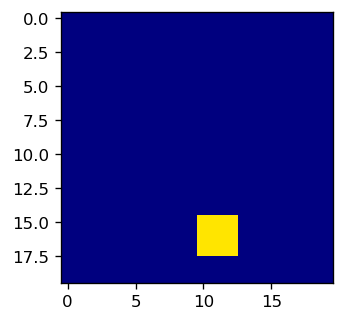

In [6]:
DibujarEspacio(Espacio)

https://www.youtube.com/watch?v=qa__LKKJ3ok <br>
Estimamos que la fagotización toma entre 10 y 20 minutos, y podemos empezar considerando pasos de 15 minutos, para un total de 96 pasos en un día. 

In [7]:
def MovimientoL(coordenada):
    '''
    input: coordenada de la leishmania
    output: nueva coordenada de la leishmania después de un paso
    '''
    vecindad = VecindadPrimerOrden(coordenada)
    paso = random.choice(vecindad)
    Espacio[coordenada[0]][coordenada[1]] = 0
    coordenada = paso
    Espacio[coordenada[0]][coordenada[1]] = 1
    return coordenada

In [8]:
def MovimientoM(coordenada, z = None):
    '''
    input: coordenada del macrófago
    output: nueva coordenada del macrófago después de un paso
    '''
    if z == None:
        z = 2
    vecindad = VecindadSegundoOrden(coordenada)
    paso = random.choice(vecindad)
    GrafMacro(coordenada, 0)
    coordenada = paso
    GrafMacro(coordenada, z)
    
    return coordenada

Ahora, queremos que el macrófago cambie su comportamiento cuando detecte una leishmania en la cercanía, de forma que en cada paso subsecuente se dirija en la dirección de la leishmania. Consideraremos que la "cercanía" es la vecindad de segundo orden del macrófago, es decir, la cuadrícula de 7x7 que tiene al macrófago (de 3x3) en el centro.

Como estamos guardando las coordenadas de las leishmanias y de los macrófagos fuera del espacio, puede ocurrir que se traslapen al momento de moverse. Al momento de la persecución, consideraremos solo una de las leishmanias en su vecindad, la primera que encuentre. Puede ser el caso de que se encimen en algún momento, ya sea leishmanias con leishmanias, o leishmanias y macrófagos infectados, que no fagocitan. 

In [9]:
def VecindadBuscarLeishmania(coordenada):
    '''
    Vecindad donde buscamos leishmanias, a partir de la coordenada central del macrófago
    input: coordenada del centro del macrófago que busca
    output: lista con 40 tuples de dos elementos, que representan las coordenadas de los 
            vecinos que queremos saber si son leishmanias
    '''
    vecindad = []
    for i in range(-3,4):
        for j in range(-3,4):
            if i!=0 or j!=0:
                vecindad.append(((i+coordenada[0])%N,(j+coordenada[1])%N))
    vecindad = [x for x in vecindad if (x not in VecindadPrimerOrden(coordenada))]
    #Si la leishmania está en la vecindad de primer orden de la celda central, 
    #consideramos que fue fagocitada y se debe realizar un proceso distinto
    return vecindad
    

In [10]:
def BuscarLeish(macro):
    '''
    Busca leishmanias en las 40 celdas de la vecindad definida, si no hay ninguna, regresa
    None, si encuentra alguna, regresa la coordenada de la primera que encuentre
    '''
    vecindad = VecindadBuscarLeishmania(macro)
    for i in range(40):
            if Espacio[vecindad[i][0]][vecindad[i][1]] == 1:
                coordenada = (vecindad[i][0], vecindad[i][1])
                return coordenada
        
    

Nota: Considerando este método, como detectamos la leishmania a distancia 2, y los pasos del macrófago son a la vecindad de segundo orden del centro, la persecución dura exactamente un movimiento. Por ahora consideramos esa vecindad por el tiempo que toma revisar vecindades más grandes.

In [11]:
def Distancia(a,b):
    '''
    Distancia entre los puntos a, b
    '''
    dist = ((a[0]-b[0])**2+(a[1]-b[1])**2)**(1/2)
    return round(dist,1)

In [12]:
def Persecucion(macro, leish):
    '''
    Un paso del macrófago que ya encontró una leishmania. El paso será en la 
    dirección en que se encuentre la leishmania en ese momento. 
    
    input: coordenadas del macrófago y la leishmania que persigue
    output: nueva coordenada del macrófago en la dirección de la leishmania
    '''
    
    #consideraremos la distancia de cada punto en la vecindad a la leishmania, y nos 
    #quedamos con el punto en la vecindad que tenga menor distancia
    vecindad = VecindadSegundoOrden(macro)
    distmin = Distancia(leish, vecindad[0])
    punto = 0
    for i in range(1,16):
        dist = Distancia(leish, vecindad[i])
        
        if dist < distmin:
            distmin = dist
            punto = i
    
    #ahora movemos el macrófago a ese punto, ajustando el espacio acordemente
    GrafMacro(macro, 0)
    macro = vecindad[punto]
    GrafMacro(macro)
    
    return macro

In [13]:
def ReproduccionL(y):
    '''
    recibe macrofagos[y], la llave del diccionario de los macrofagos
    
    macrofagos[y] = [coordenada, estado de infeccion, tiempo]
    '''
    
    GrafMacro(macrofagos[y][0], 0) #cambiar espacio
    vecindad = VecindadSegundoOrden(macrofagos[y][0])
    for i in vecindad:
        leishmanias.append(i) #meter a la lista
        Espacio[i[0]][i[1]] = 1 #meter al espacio

    macrofagos[y] = [(None, None), False, 0] #sacarlo de la lista
    return 

In [18]:
def ReproduccionM(imacro):
    """Reproduccion de macrófagos, generar cada día***tentativo el n = (10% de los macrófagos iniciales)***
        Se van van a tomar 2n coordenadas al azar y de ahí se van a asignar los nuevos macrófagos """
    n = int(imacro*0.1)
    coor_cho = random.sample(coordenadas,2*n)
    aux =0
    primer_ind = max(macrofagos.keys())
    for coord in coor_cho:
        if Espacio[coord[0]][coord[1]] == 0:
            aux += 1
            macrofagos[primer_ind + aux] = [coord ,False, 0]
            
        if aux==10: 
            break
    return

In [21]:
def MuerteM(proba, time):
    """Los macrófagos no infectados con tiempo de vida mayor a time se mueren con probabilidad p"""
    for i in macrofagos.keys():
        if macrofagos[i][1] == False and macrofagos[i][2] > time:
            aux = random.random()
            if aux < proba:
                GrafMacro(macrofagos[i][0], 0)
                macrofagos[i] = [(None, None), False, 0]
                
    return

0.04117812829964895

# Iniciar simulación

In [14]:
N = 200 #tamaño del espacio
Le = []
Inf = []
Sano = [] 

coordenadas = [] #Tuples de todas las posibles coordenadas en el espacio
for i in range(N):
    for j in range(N):
        coordenadas.append((i,j))

#iniciamos un diccionario que contendrá las coordenadas de los macrofagos, y su estado y tiempo de infección
macrofagos = dict() 
temp = random.sample(coordenadas, 100) #cuántos macrófagos
for i in range(len(temp)):
      macrofagos[i] = [temp[i], False, 0] #su estado de infección y su tiempo de infección, originalmente ninguno está infectado y su tiempo es 0


#quitamos de la lista de coordenadas todas las ocupadas por macrófagos, es decir, la central y su primera vecindad
macros_total = temp.copy()
for i in temp: 
    temp3 = VecindadPrimerOrden(i)
    for j in temp3:
        macros_total.append(j)

coordenadas = [x for x in coordenadas if x not in macros_total] 

leishmanias = random.sample(coordenadas, 10) #lista con las coordenadas representando leishmanias

#Iniciamos el espacio
Espacio = np.zeros((N,N))



#Ajustamos los valores en el espacio 
for i in macrofagos.keys():
    Espacio[macrofagos[i][0][0]][macrofagos[i][0][1]] = 2
    GrafMacro(macrofagos[i][0])
for i in leishmanias:
    Espacio[i[0]][i[1]] = 1

#%matplotlib inline
#DibujarEspacio(Espacio)

Espacios = []

In [15]:
#DibujarEspacio(Espacio)

for i in range(900):
    Espacios.append(Espacio.copy()) #guardamos cada iteración del espacio para la animación
    macrostemp = {} #reemplazaremos el diccionario cada iteración para poder modificar las llaves conforme iteramos por los macrofagos
    for y in macrofagos.keys():
        
        if macrofagos[y][1] == True: #si está infectada, su tiempo aumenta 1
            if macrofagos[y][2] == 280:
                ReproduccionL(y)
            
            else:
                macrofagos[y][2] += 1
                macrofagos[y][0] = MovimientoM(macrofagos[y][0], 3) #paso aleatorio, color 3
                macrostemp[y] = macrofagos[y] ##
                
        else: #si no está infectada, busca a quien fagocitar
            
            a = BuscarLeish(macrofagos[y][0])
            if  a == None: #si no hay nadie, paso aleatorio
                macrofagos[y][0] = MovimientoM(macrofagos[y][0])
            
            else: #si sí, da el paso hacia ella
                #print(a)
                macrofagos[y][0] = Persecucion(macrofagos[y][0], a)
                if a in VecindadPrimerOrden(macrofagos[y][0]) or a == macrofagos[y][0]: #en realidad no es necesario porque siempre debe ser cierto
                    p = random.random() 
                    #print(p)
                    
                    #leishmania fagocitada
                    leishmanias.remove(a)
                    
                    if p < 0.75: #se infecta
                        macrofagos[y][1] = True
                        GrafMacro(macrofagos[y][0], 3)
            
            macrostemp[y] = macrofagos[y]

    
    macrofagos = macrostemp
    
    for x in range(len(leishmanias)):
        leishmanias[x] = MovimientoL(leishmanias[x])
                    
    L = len(leishmanias)
    I = 0
    S = 0
    for x in macrofagos.keys():
        if macrofagos[x][1] == True:
            I += 1 
        else:
            S += 1
    Le.append(L) #lista con cantidad de leishmanias, macrófagos sanos, macrófagos infectados
    Inf.append(I)
    Sano.append(S)
    
    
    #DibujarEspacio(Espacio)

    

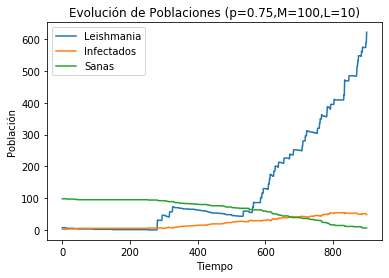

In [16]:
#%matplotlib inline
plt.figure()
plt.title('Evolución de Poblaciones (p=0.75,M=100,L=10)')
plt.ylabel('Población')
plt.xlabel('Tiempo')

t = np.linspace(0, 899, 900)


plt.plot(t, Le, label = 'Leishmania')
plt.plot(t, Inf, label = 'Infectados')
plt.plot(t, Sano, label = 'Sanas')
plt.legend(loc = 'upper left')

#plt.savefig('p75M100L10.png')
plt.show()
plt.close()



<IPython.core.display.Javascript object>


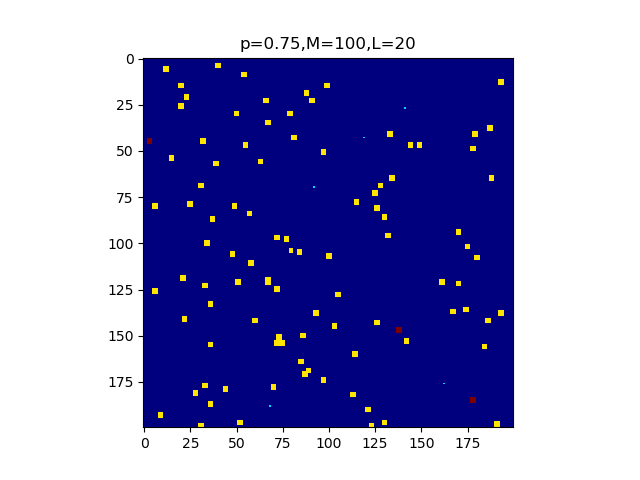

In [17]:
#Animación para ver la evolución a lo largo del tiempo

# Required line for plotting the animation
%matplotlib notebook

my_board = Espacios[0]

# Initialize the plot of the board that will be used for animation
fig = plt.gcf()

plt.title('p=0.75,M=100,L=20')

# Show first image - which is the initial board
im = plt.imshow(my_board, vmin=0,vmax = 3, cmap='jet')
plt.show()

# Helper function that updates the board and returns a new image of
# the updated board animate is the function that FuncAnimation calls
def animate(i):
    im.set_data(Espacios[i])
    return im,
# This line creates the animation
anim = animation.FuncAnimation(fig, animate, frames=300, 
                               interval=200)


#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

Writer = animation.FFMpegWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)

#anim.save('p75M100L20.mp4', writer=Writer)